In [1]:
import contextlib
from dataclasses import astuple, asdict
import datetime
import functools
import itertools
from importlib import reload
from io import StringIO
from pprint import pprint as pp
import logging
import multiprocessing
FORMAT = '%(asctime)-15s %(levelname)-5s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
import numpy as np; import pandas as pd; from pandas import Series, DataFrame; pd.set_option('max_columns', 50)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

In [3]:
import aggregation_api.day_summary as D; reload(D);
import aggregation_api.utils as U; reload(U);
import aggregation_api.smart_weight_metrics_v6 as S; reload(S);
import aggregation_api.smart_lice_metrics as L; reload(L);

# ENGALL-2003 Sudden Change in Weight Dale Pen 3

Swapping in USB camera increase sample size. We know many of these samples are duplications. The theory is these duplication distort the average weight trend line. We have a custom version of the biomass aggregation that subsamples (e.g. maximum one sample every 2 seconds). By comparing the existing calculation from the day summary db v.s. the subsampled calculation, we can test if this make change to the average weight to comform to our expectation more.

[ENGALL-2003 Sudden Change in Weight Dale Pen 3](https://aquabyte.atlassian.net/browse/ENGALL-2003)

In [4]:
reload(D)

data_store = "PROD_STAGING"
dry_run = True

# Run query_day_summary() and biomass_sum_pen() parallel for comparison
def bio_q_n_a(date, num_days, pen_ids):
    rows_q = D.query_day_summary(date, num_days, data_store, pen_ids, True, False)
    rows_a = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])
    df_q = pd.DataFrame(asdict(U.biomass_summary_digest(date, data)) for date, data in rows_q.items())
    df_a = pd.DataFrame(asdict(U.biomass_summary_digest(date, data)) for date, data in rows_a.items())
    return df_q, df_a

def plot_comp(df_q, df_a, pen_ids, name, swap_date, figsize=(12,8)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2,figsize=figsize, facecolor='w')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=8)

    swap_date = datetime.date.fromisoformat(swap_date)

    df = df_q.set_index('date')
    with contextlib.redirect_stderr(StringIO()):
        df.r_numFish.plot.bar(ax=ax1, rot=90)
        df.s_avgWeight.plot(ax=ax2, label='smart', rot=90)
        df.r_avgWeight.plot(ax=ax2, label='raw', rot=90)
        ax2.axvline(swap_date, color='#777')
    ax1.set_title('num sample')
    ax2.set_title('weight')
    ax2.legend()

    df = df_a.set_index('date')
    with contextlib.redirect_stderr(StringIO()):
        df.r_numFish.plot.bar(ax=ax3, rot=90)
        df.s_avgWeight.plot(ax=ax4, label='smart', rot=90)
        df.r_avgWeight.plot(ax=ax4, label='raw', rot=90)
    ax3.set_title('num sample subsampled')
    ax4.set_title('weight subsampled')
    ax4.legend()  
        
    fig.suptitle(f"{name} (id={pen_ids[0]}), swap={swap_date}")

In [ ]:
# sanity test
date = datetime.date.fromisoformat('2021-02-09')
num_days = 30
pen_ids = [145]
df_q, df_a = bio_q_n_a(date, num_days, pen_ids)

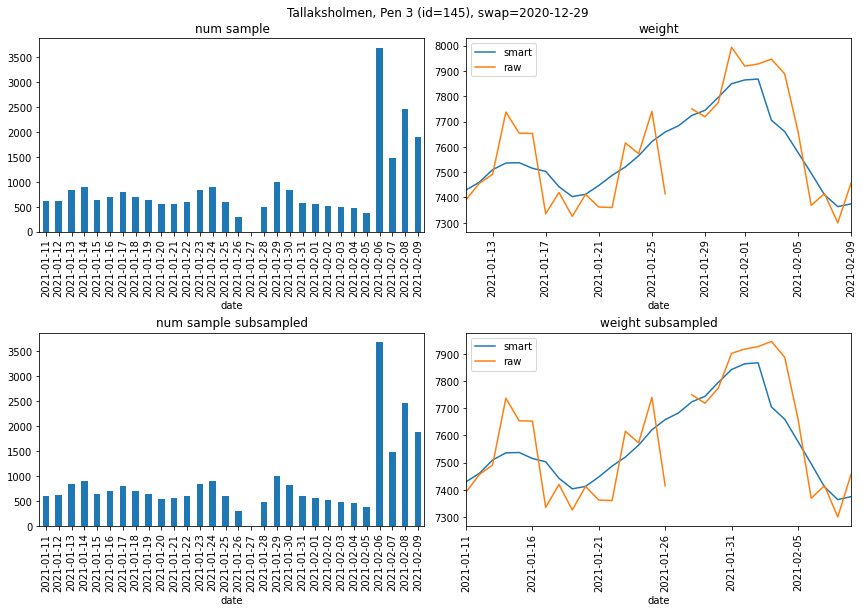

In [639]:
plot_comp(df_q, df_a, pen_ids, "Tallaksholmen, Pen 3", swap_date='2020-12-29')

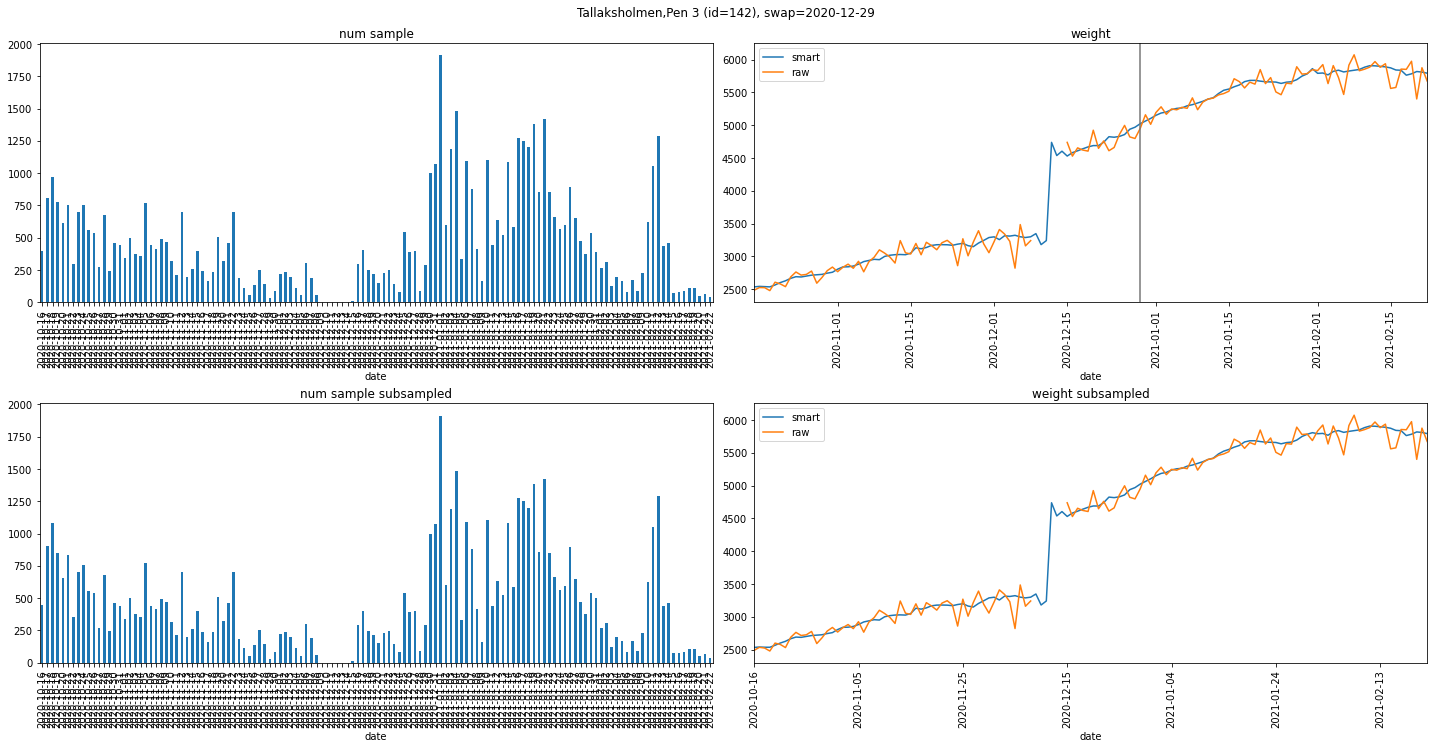

In [36]:
plot_comp(df_q, df_a, pen_ids, "Tallaksholmen,Pen 3", swap_date='2020-12-29', figsize=(20,10))

### Kjeppevikholmen,Pen 2 | 2021-01-14 09:29:35

In [640]:
pen_ids = [1]
date = datetime.date.fromisoformat('2021-01-31')
num_days = 34
df_q, df_a = bio_q_n_a(date, num_days, pen_ids)

2021-03-18 09:26:50,169 INFO  Fetched 34 rows in 1.80s
2021-03-18 09:26:50,176 INFO  agg_data:
          date  r_avgWeight  r_numFish  s_avgWeight  s_biomassKPI  s_numFish
0   2020-12-29  3070.041402        776  3061.729966      1.435406       4643
1   2020-12-30  3147.908583        476  3081.815317      1.318203       4734
2   2020-12-31  3113.128647       1039  3092.562354      1.446824       5471
3   2021-01-01  3104.580647       1035  3101.970658      1.610905       4990
4   2021-01-02  3084.258977        465  3109.223561      1.342915       4214
5   2021-01-03  3095.381750       1114  3105.900911      1.589434       3738
6   2021-01-04  3088.825601         85  3104.956314      0.519354       3002
7   2021-01-05          NaN          0  3121.681466           NaN       2742
8   2021-01-06          NaN          0  3136.405481           NaN       2801
9   2021-01-07  3146.785372        303  3139.194435      1.156154       2385
10  2021-01-08  3175.727411        775  3157.455950      1

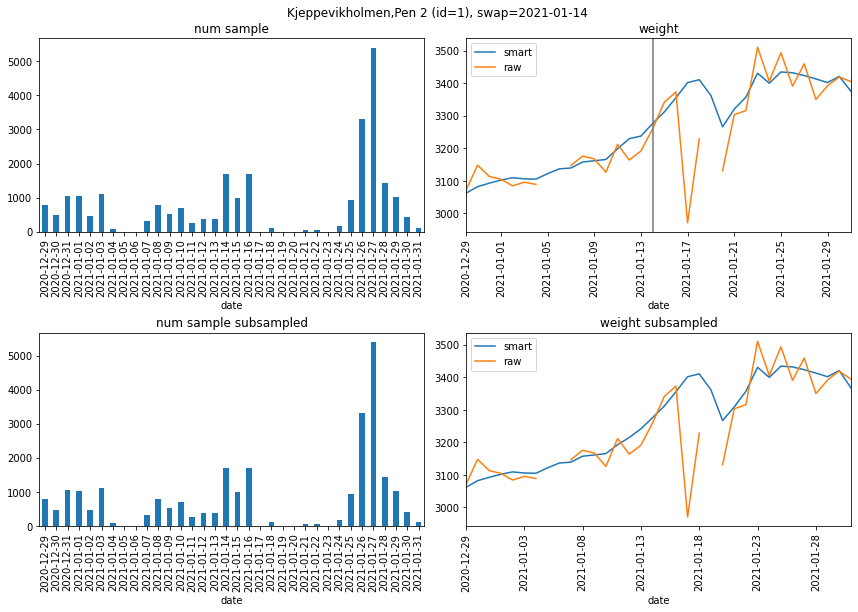

In [644]:
plot_comp(df_q, df_a, pen_ids, "Kjeppevikholmen,Pen 2", swap_date='2021-01-14')

### Kjeppevikholmen,Pen 3| 2021-01-14 10:10:39

In [ ]:
pen_ids = [5]
date = datetime.date.fromisoformat('2021-01-31')
num_days = 36
rows = D.query_day_summary(date, num_days, data_store, pen_ids)
rows_ss = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])

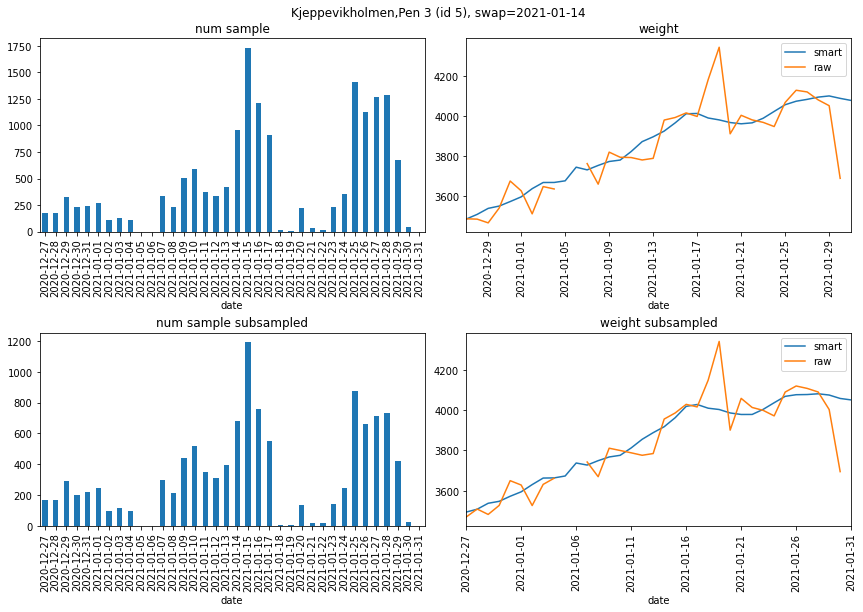

In [338]:
plot_comp(rows, rows_ss, "Kjeppevikholmen,Pen 3", swap_date='2021-01-14')

### 61,IMR Austevoll,Pen 1| 2020-11-05 09:12:4

In [ ]:
pen_ids = [61]
date = datetime.date.fromisoformat('2020-11-25')
num_days = 26
rows = D.query_day_summary(date, num_days, data_store, pen_ids)
rows_ss = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])

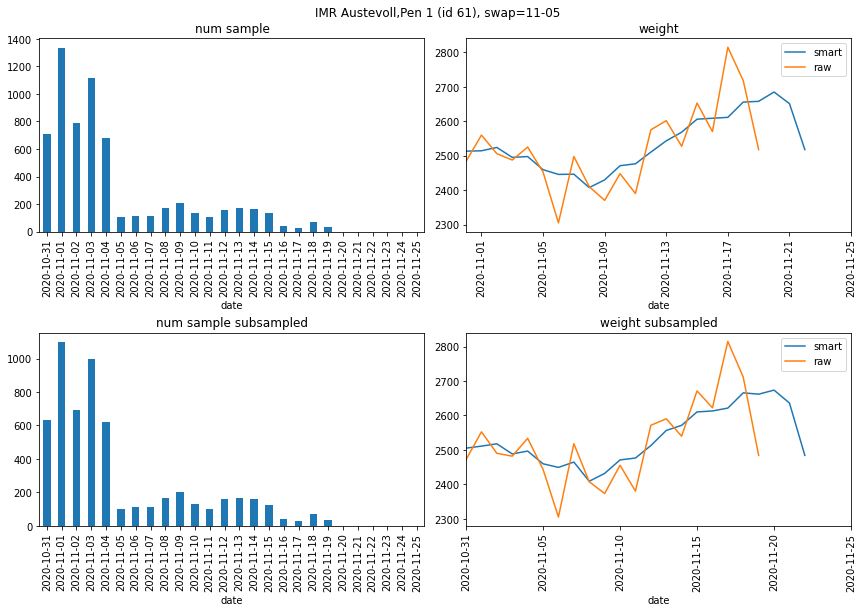

In [348]:
plot_comp(rows, rows_ss, "IMR Austevoll,Pen 1", swap_date='11-05')

### 122,Midtflua,Pen 3 | 2020-11-10 09:33:59

In [ ]:
pen_ids = [122]
date = datetime.date.fromisoformat('2020-11-27')
num_days = 36
rows = D.query_day_summary(date, num_days, data_store, pen_ids)
rows_ss = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])

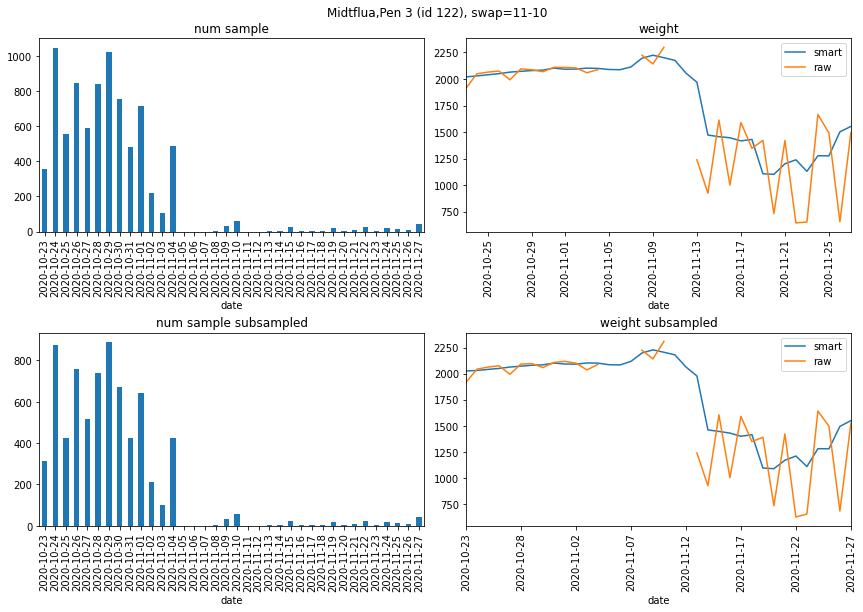

In [340]:
plot_comp(rows, rows_ss, "Midtflua,Pen 4", swap_date='11-10')

### 123,Midtflua,Pen 4 | 2020-11-10 10:24:21

In [ ]:
pen_ids = [123]
date = datetime.date.fromisoformat('2020-11-27')
num_days = 36
rows = D.query_day_summary(date, num_days, data_store, pen_ids)
rows_ss = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])

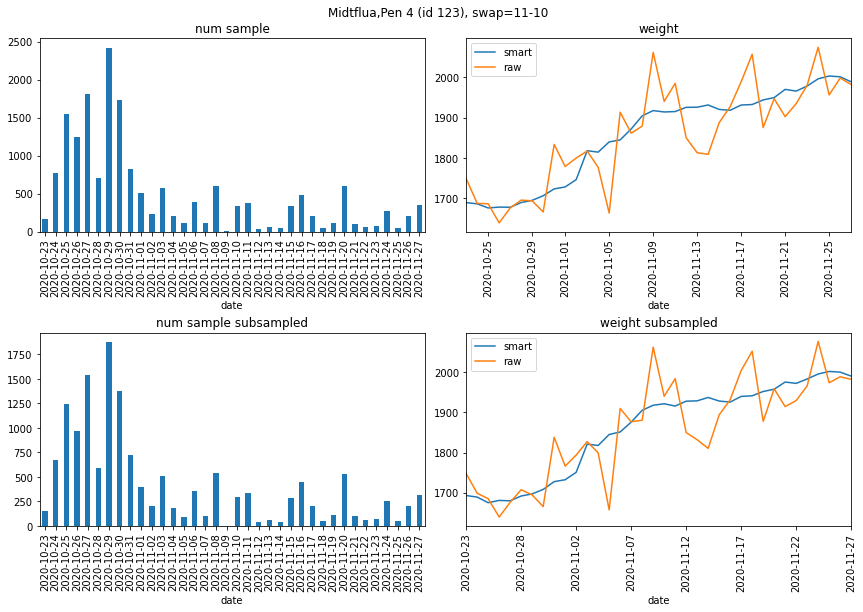

In [342]:
plot_comp(rows, rows_ss, "Midtflua,Pen 4", swap_date='11-10')

### 140,Tallaksholmen,Pen 1 | 2021-01-02 12:22:34.051917+00:00

In [ ]:
reload(D)
pen_ids = [140]
date = datetime.date.fromisoformat('2021-02-22')
num_days = 135
df_q, df_a = bio_q_n_a(date, num_days, pen_ids)

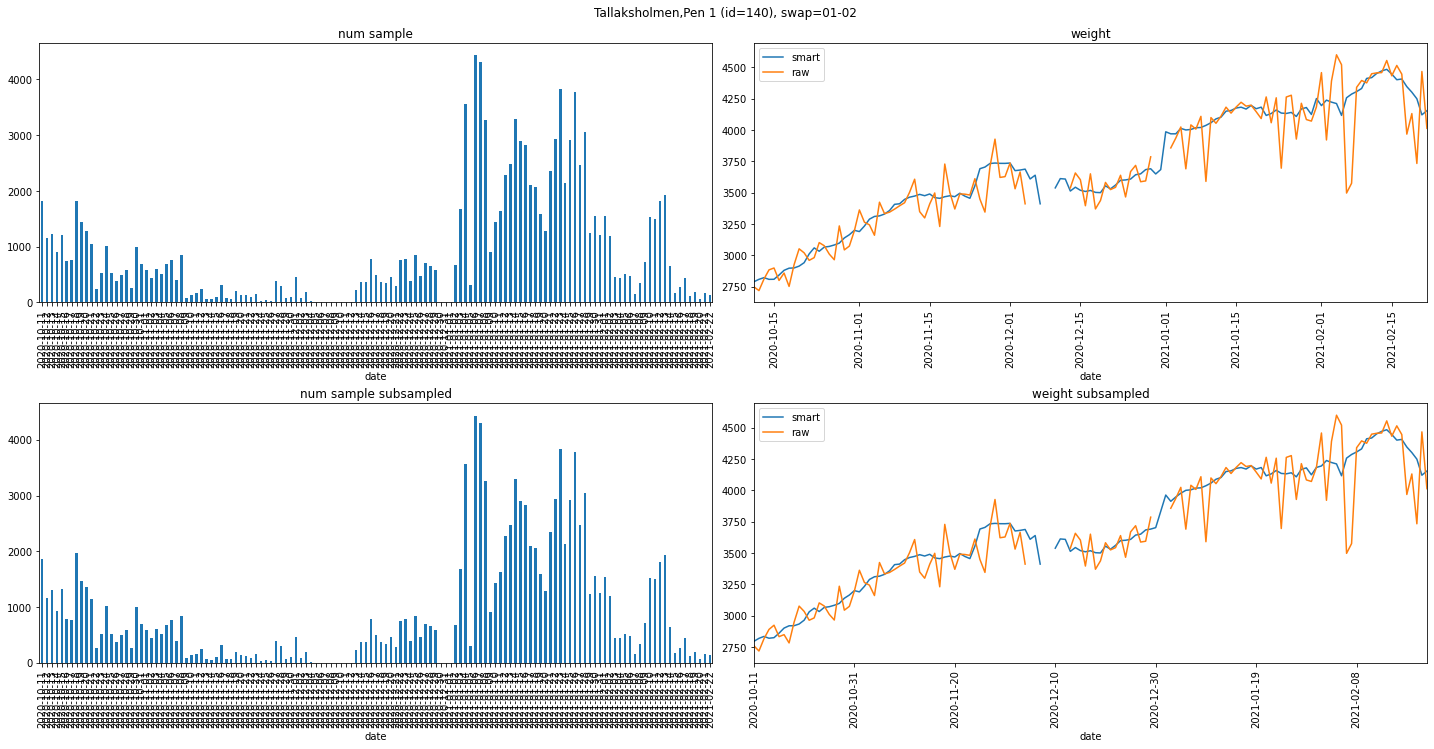

In [23]:
plot_comp(df_q, df_a, pen_ids, name="Tallaksholmen,Pen 1", swap_date='01-02', figsize=(20,10))

### 142,Tallaksholmen,Pen 3 | 2020-12-29 12:52:

In [ ]:
pen_ids = [142]
date = datetime.date.fromisoformat('2021-02-22')
num_days = 130
df_q, df_a = bio_q_n_a(date, num_days, pen_ids)

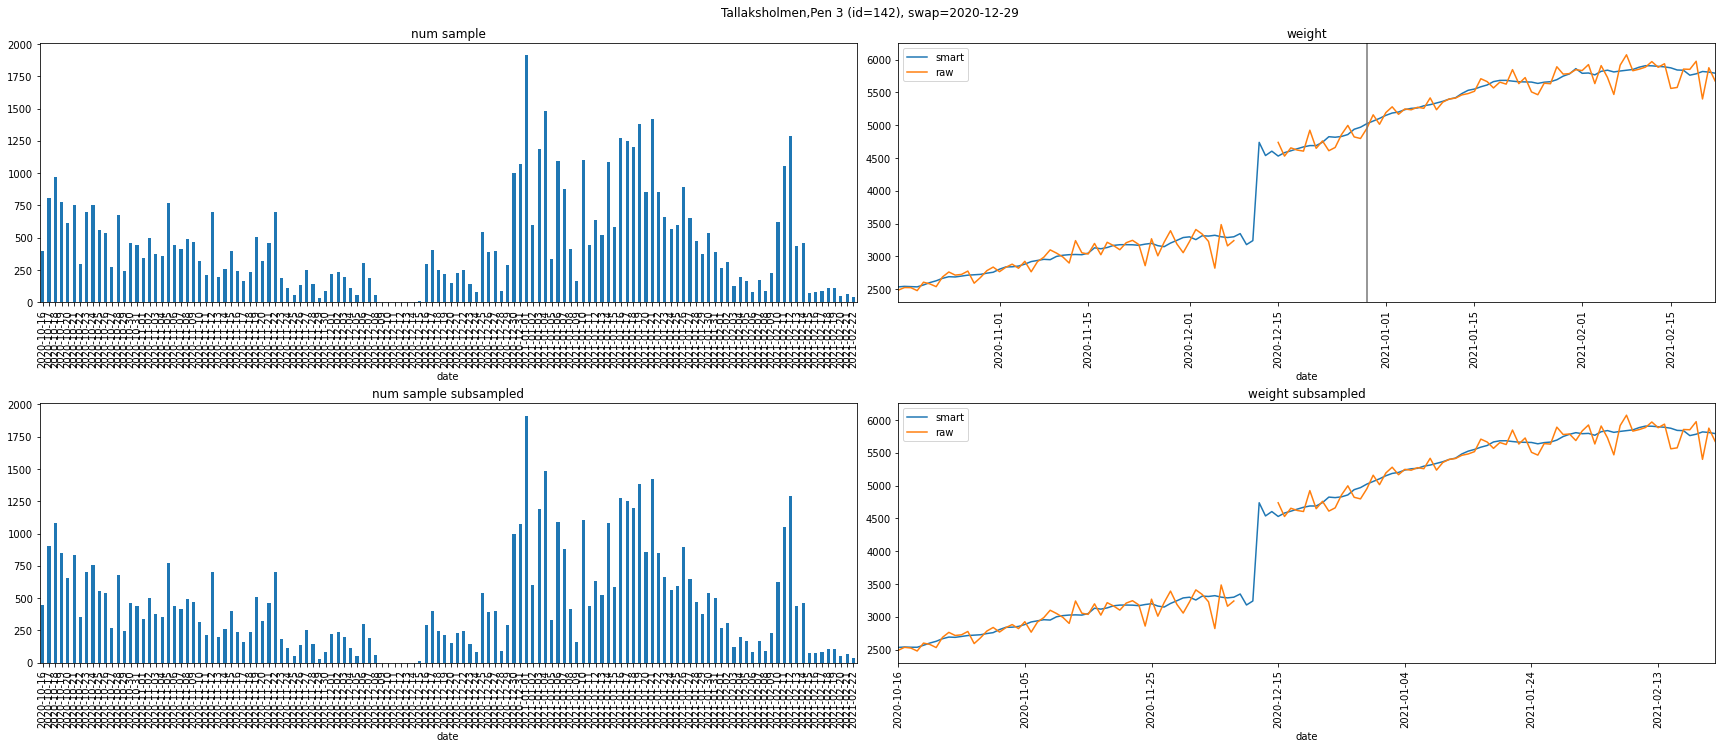

In [38]:
plot_comp(df_q, df_a, pen_ids, "Tallaksholmen,Pen 3", swap_date='2020-12-29', figsize=(24,10))

### 145,Dale,Pen 3 | 2021-02-05 14:34:11

In [12]:
reload(D)
pen_ids = [145]
date = datetime.date.fromisoformat('2021-02-16')
num_days = 100
df_q, df_a = bio_q_n_a(date, num_days, pen_ids)

2021-02-22 14:10:29,845 INFO  Fetched 103185 rows in 10.31s
2021-02-22 14:10:29,856 INFO    estimate_feeding_hour -> [7..16); counts 103185 -> 103099
2021-02-22 14:10:29,905 INFO  process_result: raw=103185; subsampled=103185 (rate=2); feeding hour=103099
2021-02-22 14:10:33,228 INFO    elapsed=15s rows=100


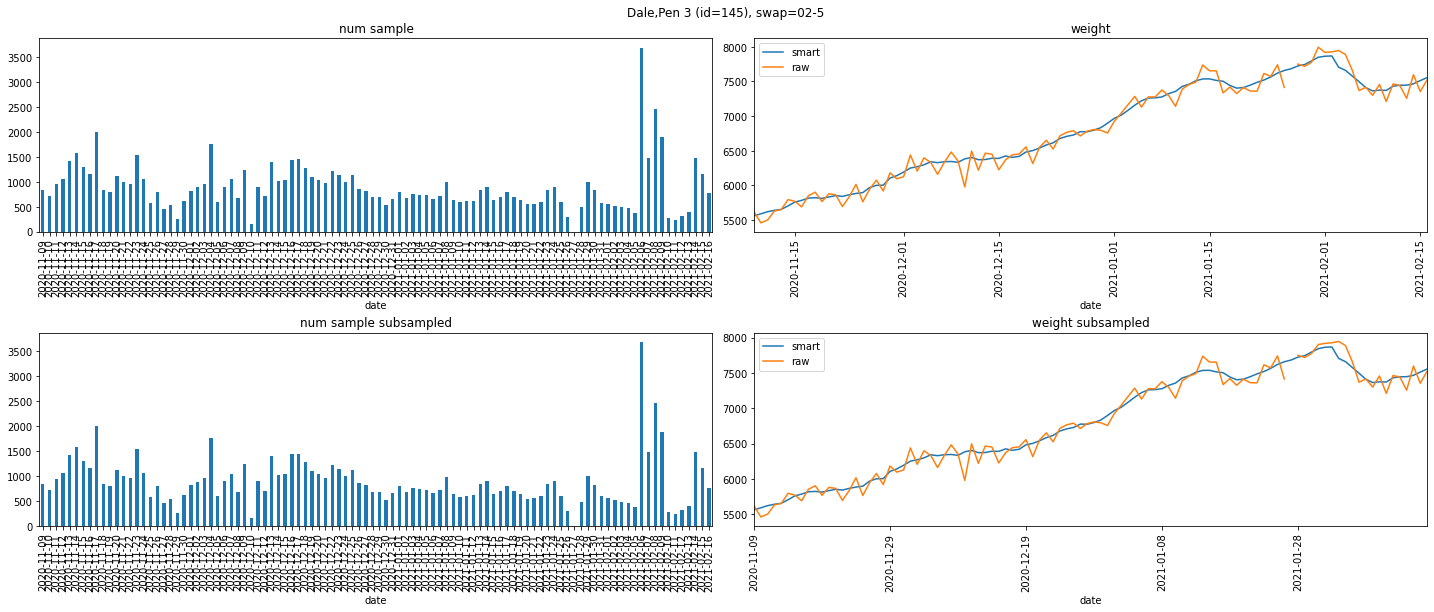

In [17]:
plot_comp(df_q, df_a, pen_ids, "Dale,Pen 3", swap_date='02-5', figsize=(20,8))

### 173,Laksevika,Pen 9 | 2020-12-09 09:17:06.1

In [ ]:
pen_ids = [173]
date = datetime.date.fromisoformat('2020-12-26')
num_days = 36
rows = D.query_day_summary(date, num_days, data_store, pen_ids)
rows_ss = D.biomass_sum_pen(date, num_days, data_store, dry_run, pen_ids[0])

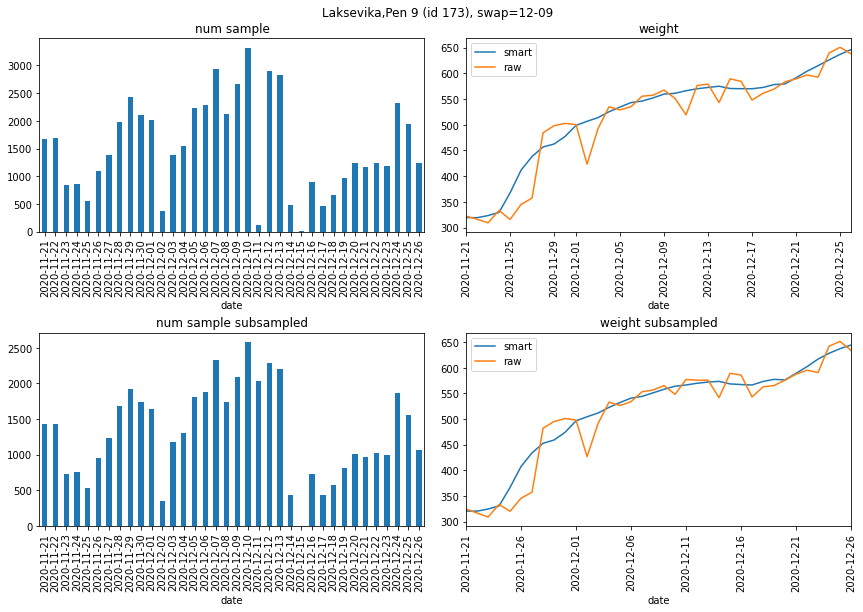

In [331]:
plot_comp(rows, rows_ss, "Laksevika,Pen 9", swap_date='12-09')

# Bootstrapping

[3/17/21 Estimate Variance of Average Weight Using Bootstrapping](https://aquabyte.atlassian.net/wiki/spaces/Research/pages/1165656065/3+17+21+Estimate+Variance+of+Average+Weight+Using+Bootstrapping)

## Load data

In [5]:
reload(S)
def smart_metrics_date_params(pen_id: int, start_date: str, end_date: str, dates_to_reset):
    dates_to_include = S.get_dates_in_range(S.add_days(start_date, -7), S.add_days(end_date, 7))
    dates_to_reset = sorted([d for d in dates_to_reset if d in dates_to_include])
    dates_to_compute = S.get_dates_in_range(start_date, end_date)
    return dates_to_include, dates_to_reset, dates_to_compute

In [701]:
pen_id     = 5
start_date = '2021-01-01'
end_date   = '2021-03-10'
sampling_filter = S.get_optimal_sampling_filter(pen_id)
dates_to_include, dates_to_reset, dates_to_compute = smart_metrics_date_params(pen_id, start_date, end_date, [])
#biomass_rows = S.get_biomass_data_from_db(pen_id, dates_to_include, sampling_filter)

biomass_df = pd.DataFrame(biomass_rows)
filename = f'pen_{pen_id}_{start_date}_{end_date}_biomass_data.csv'
print(f"Writing {len(biomass_df)} to {filename}")
biomass_df.to_csv(filename, header=False, index=False)

2021-03-18 10:56:31,488 INFO  Fetched 1 rows in 1.22s


Writing 27234 to pen_5_2021-01-01_2021-03-10_biomass_data.csv


In [6]:
pen_id     = 86
start_date = '2020-12-01'
end_date   = '2021-03-10'
sampling_filter = S.get_optimal_sampling_filter(pen_id)
dates_to_include, dates_to_reset, dates_to_compute = smart_metrics_date_params(pen_id, start_date, end_date, [])
biomass_rows = S.get_biomass_data_from_db(pen_id, dates_to_include, sampling_filter)

biomass_df = pd.DataFrame(biomass_rows)
filename = f'pen_{pen_id}_{start_date}_{end_date}_biomass_data.csv'
print(f"Writing {len(biomass_df)} to {filename}")
biomass_df.to_csv(filename, header=False, index=False)

2021-03-18 16:07:44,657 INFO  Found credentials in shared credentials file: ~/.aws/credentials
2021-03-18 16:07:46,047 INFO  ssm: DATA_WAREHOUSE -> host=aquabyte-service-metadata-readreplica.cfwlu7jbdcqj.eu-west-1.rds.amazonaws.com dbname=aquabyte_prod_dw user=service_research_services
2021-03-18 16:07:47,316 INFO  Fetched 1 rows in 2.68s


NameError: name 'biomass_rows' is not defined

In [7]:
# load from csv
filename = f'pen_{pen_id}_{start_date}_{end_date}_biomass_data.csv'
biomass_df = pd.read_csv(filename, header=None)
biomass_df[0] = biomass_df[0].apply(pd.to_datetime)
print(f"{filename} -> {len(biomass_df)} from {biomass_df[0].min().date()} to {biomass_df[0].max().date()}")

pen_86_2020-12-01_2021-03-10_biomass_data.csv -> 155463 from 2020-11-24 to 2021-03-17


## Smart average baseline

In [8]:
pen_id     = 86
start_date = '2020-12-01'
end_date   = '2021-03-10'
sampling_filter = S.get_optimal_sampling_filter(pen_id)
dates_to_include, dates_to_reset, dates_to_compute = smart_metrics_date_params(pen_id, start_date, end_date, [])

2021-03-18 16:08:24,433 INFO  Fetched 1 rows in 1.22s


2021-03-18 16:08:24,911 INFO    (optimal_sampling_filter) feeding_hour -> [7..16)
2021-03-18 16:08:25,035 INFO  process_result: raw=155463; subsampled=155463 (rate=2); feeding hour=56938


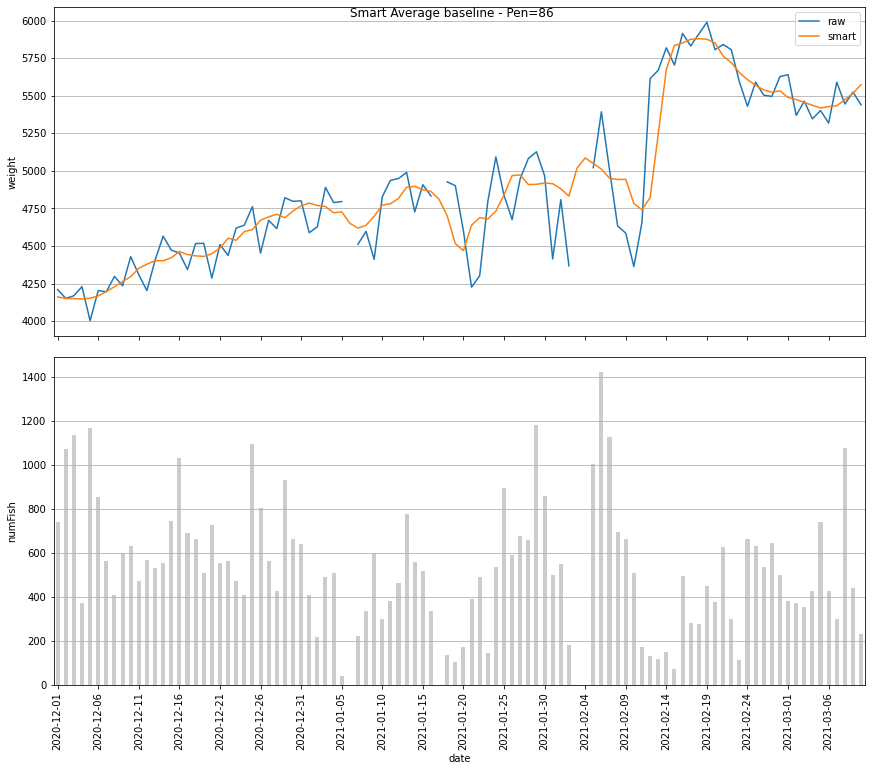

In [9]:
agg_data = S._generate_smart_metrics_step2(dates_to_include, dates_to_reset, dates_to_compute, sampling_filter, biomass_df.to_numpy())
df = U.biomass_digest_df(agg_data)
df = df.sort_values(by='date').set_index('date')
df_smart = df

fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,10),sharex=True, facecolor='w')
fig.tight_layout()
with contextlib.redirect_stderr(StringIO()):
    df.r_avgWeight.plot(ax=ax1,label='raw')
    df.s_avgWeight.plot(ax=ax1,label='smart')
    df.r_numFish.plot.bar(ax=ax2, color='#ccc')
    ax1.grid(axis='y')
    ax1.set_ylabel('weight')
    ax1.legend()
    ax2.grid(axis='y')
    ax2.xaxis.set_major_locator(MaxNLocator(20)) 
    ax2.set_ylabel('numFish')
    fig.suptitle(f'Smart Average baseline - Pen={pen_id}')

## Resampling and bootstrapping

In [ ]:
def resample_by_day(df, day_column):
    idx_groups = df.groupby(by=day_column).apply(
        lambda gi: np.random.choice(gi.index, len(gi), replace=True)
    )
    idx_flat = pd.Series(
        itertools.chain.from_iterable(
            group for group in idx_groups
        )
    )
    resampled_df = df.loc[idx_flat]
    return resampled_df.sort_index()

test_df = pd.DataFrame({'day': [1,1,1,2,2,2,3,3,3,3], 'metric': np.arange(10)})
resample_by_day(test_df, 'day')

In [736]:
reload(S)

def bootstrap_iteration(i, df, pen_id, start_date, end_date, dates_to_include, dates_to_reset, dates_to_compute, estimate_feeding_hour=False):    
    print(f'Iteration {i+1}')   
    np.random.seed()

    num_calculation = len(dates_to_compute) - 4
    estimated_start_hour = np.zeros(num_calculation, np.int32)
    estimated_end_hour = np.zeros(num_calculation, np.int32)
    
    resampled_df = resample_by_day(df, day_column=1)
    
    sampling_filter = S.get_optimal_sampling_filter(pen_id)
    sampling_filter["estimate_feeding_hour"] = estimate_feeding_hour

    agg_data = {}
    for j in range(num_calculation):    
        di = dates_to_include[j:j+5+7+7]
        dc = dates_to_compute[j:j+5]
        if j+1 < num_calculation:
            di_end = dates_to_include[j+5+7+7]
        else:
            di_end = '2030-12-31'
        df_in_date = resampled_df[((resampled_df[0] >= di[0]) & (resampled_df[0] < di_end))]
        
        agg_j = S._generate_smart_metrics_step2(di, dates_to_reset, dc, sampling_filter, df_in_date.to_numpy())
        agg_data.update(agg_j)
        # thread safe?
        estimated_start_hour[j] = sampling_filter.get("estimated_start_hour", -1)
        estimated_end_hour[j] = sampling_filter.get("estimated_end_hour", -1)

    df = U.biomass_digest_df(agg_data)
    df = df.sort_values(by='date')
    r_w = df.r_avgWeight.to_numpy()
    s_w = df.s_avgWeight.to_numpy()
    
    return r_w, s_w, estimated_start_hour, estimated_end_hour, df


POOL_SIZE = 10

def bootstrap(pen_id, df, start_date, end_date, estimate_feeding_hour, sample_size):
    dates_to_include, dates_to_reset, dates_to_compute = smart_metrics_date_params(pen_id, start_date, end_date, [])
    
    b_func = functools.partial(bootstrap_iteration, df=df, pen_id=pen_id, start_date=start_date, end_date=end_date, 
                               dates_to_include=dates_to_include, dates_to_reset=dates_to_reset, dates_to_compute=dates_to_compute, 
                               estimate_feeding_hour=estimate_feeding_hour)

    with multiprocessing.Pool(processes=POOL_SIZE) as pool:
        result = pool.map(b_func, range(sample_size), chunksize=1)

    agg_df = result[0][4] # use the first df for now
    r_w = np.array([r[0] for r in result]).T
    s_w = np.array([r[1] for r in result]).T
    start_hours = np.array([r[2] for r in result])
    end_hours = np.array([r[3] for r in result])

    logging.info(f"Bootstrap size={sample_size} -> r_w={len(r_w)}, s_w={len(s_w)}, dates={len(dates)})")
    
    return agg_df, r_w, s_w, start_hours, end_hours

In [749]:
pen_id = 5
SAMPLE_SIZE = 5
bootstrap_result_5 = bootstrap(pen_id, biomass_df, start_date, end_date, estimate_feeding_hour=False, sample_size=SAMPLE_SIZE)
agg_df, r_w, s_w, start_hours, end_hours = bootstrap_result 
bootstrap_result_5 = bootstrap_result

Iteration 2Iteration 3Iteration 1Iteration 4



In [ ]:
pen_id = 86
SAMPLE_SIZE = 100
bootstrap_result = bootstrap(pen_id, biomass_df, start_date, end_date, estimate_feeding_hour=False, sample_size=SAMPLE_SIZE)
agg_df, r_w, s_w, start_hours, end_hours = bootstrap_result 
bootstrap_result_86 = bootstrap_result

In [ ]:
pen_id = 86
SAMPLE_SIZE = 100
bootstrap_result = bootstrap(pen_id, biomass_df, start_date, end_date, estimate_feeding_hour=True, sample_size=SAMPLE_SIZE)
agg_df, r_w, s_w, start_hours, end_hours = bootstrap_result
bootstrap_result_86_feeding = bootstrap_result

In [768]:
def plot_bootstrap(pen_id, agg_df, s_w, title, figsize=(12,10)):
    logging.getLogger().setLevel(logging.WARNING)
    fig,(ax1,ax2) = plt.subplots(figsize=figsize, nrows=2, sharex=True, facecolor='w')
    fig.tight_layout()
    plt.xticks(rotation=90)
    
    sample_size = s_w.shape[1]

    for i in range(sample_size):
        ax1.plot(agg_df.date, s_w[:,i], lw=0.05)
    ax1.plot(agg_df.date, np.percentile(s_w, q=95, axis=1), color='#777')
    ax1.plot(agg_df.date, np.percentile(s_w, q=5, axis=1), color='#777')    
    ax1.set_ylabel('weight')
    ax1.grid(axis='y')

    ax2.plot(np.std(s_w, axis=1),label='SD')
    ax2.set_ylabel('SD')
    ax2_ = ax2.twinx()
    ax2_.bar(x=agg_df.date, height=agg_df.r_numFish, color='#ccc8',)
    ax2_.set_ylabel('num sample')
    ax2.xaxis.set_major_locator(MaxNLocator(25)) 

    fig.suptitle(f'Pen={pen_id}, {title} iterations={sample_size}')

    logging.getLogger().setLevel(logging.INFO)
    
#plot_bootstrap(pen_id, agg_df, s_w, "bootstrap", figsize=(12,6))    

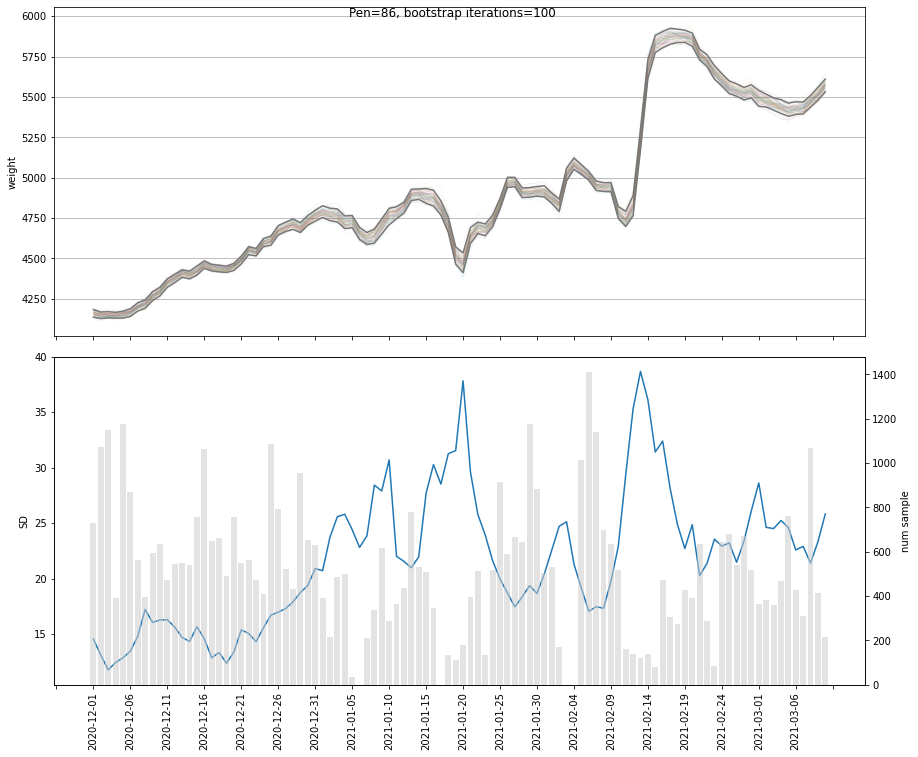

In [765]:
plot_bootstrap(pen_id, agg_df, s_w, "bootstrap", figsize=(12,10))

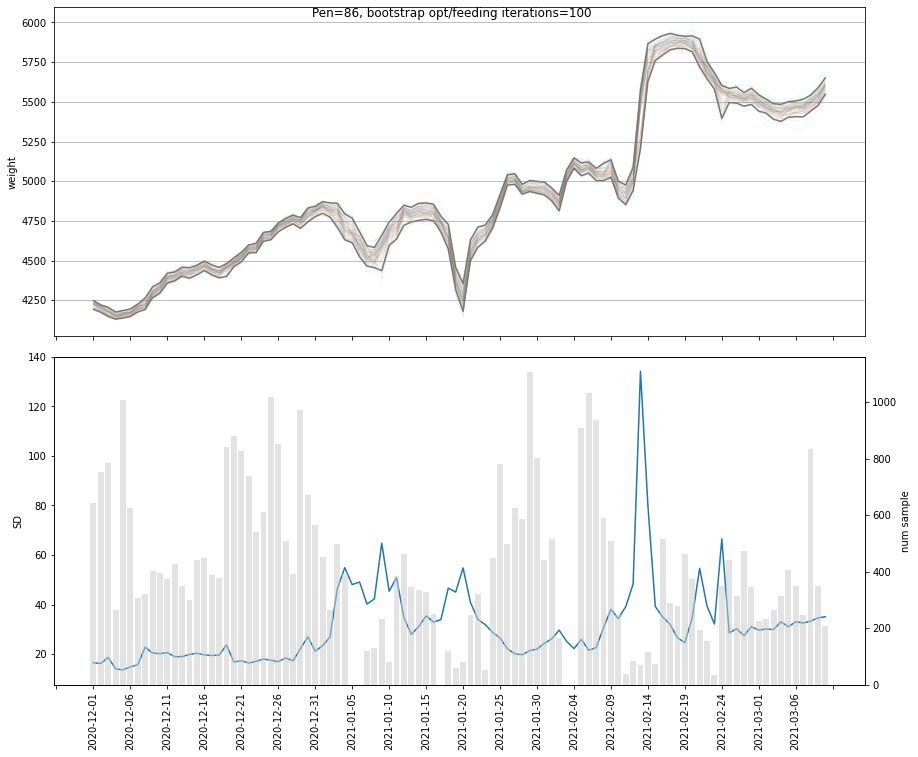

In [770]:
plot_bootstrap(pen_id, agg_df, s_w, "bootstrap opt/feeding", figsize=(12,10))

## Weighted Moving Average/Percentile

In [11]:
# https://stackoverflow.com/posts/29677616/revisions
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [12]:
# current day only
KERNEL_LEFT = 0
KERNEL_RIGHT = 0

# trianglar kernel
KERNEL_LEFT = 4
KERNEL_RIGHT = 4

KERNEL_ARRAY = np.concatenate((
    np.linspace(0.8,0,KERNEL_LEFT,endpoint=False)[::-1],
    [1.0],
    np.linspace(0.8,0,KERNEL_RIGHT,endpoint=False)
))
assert len(KERNEL_ARRAY) == KERNEL_LEFT + 1 + KERNEL_RIGHT
KERNEL_ARRAY

array([0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2])

In [13]:
def preprocess_for_moving_precentile(df):
    # filter by feeding hour [7..16)
    hours = df[0].apply(lambda dt: dt.hour)
    df = df[((hours >= 7) & (hours < 16))]

    # Add a "day" column start from 0
    dates = pd.to_datetime(df[1])
    date0 = dates.min()
    days = (dates - date0).apply(lambda d: d.days).rename("day")

    return pd.concat([df, days], axis=1)

biomass_day_df = preprocess_for_moving_precentile(biomass_df)
len(biomass_day_df)

56938

In [14]:
def weighted_metric_on_day(df, day_idx, quantiles):
    df0=df
    min_day = max(day_idx - KERNEL_LEFT, 0)
    max_day = min(day_idx + KERNEL_RIGHT, df['day'].max())

    df = df.loc[(df['day'] >= min_day) & (df['day'] <= max_day)]    
    #print(f"day={day_idx} [{min_day}..{max_day}], count={len(df)}")
    
    count = (df['day'] == day_idx).sum()
        
    weights = KERNEL_ARRAY[df['day'] - day_idx + KERNEL_LEFT]    

    if len(weights) <= 0:
        import pdb; pdb.set_trace()
        return count, np.full(len(quantiles)+1, np.nan)
    
    avg = np.average(df[2], weights=weights)
    pct = weighted_quantile(df[2], quantiles, weights)    
    return count, np.concatenate(([avg], pct))

quantiles = [0.1, 0.5, 0.9]
weighted_metric_on_day(biomass_day_df, 5, quantiles)

(164, array([4125.72685524, 3015.33842087, 4074.15573086, 5370.89219689]))

In [27]:
quantiles = [0.1, 0.5, 0.9]

date0 = biomass_day_df[0].min().date()
result = []
for day_idx in range(biomass_day_df['day'].max() + 1):
    date = str(date0 + pd.Timedelta(days=day_idx))
    count, q = weighted_metric_on_day(biomass_day_df, day_idx, quantiles)
    result.append(dict(
        day_idx = day_idx,
        date    = date,
        count   = count,
        mean    = q[0],
        p10     = q[1],
        p50     = q[2],
        p90     = q[3],        
    ))
                  
moving_df = pd.DataFrame(result).set_index('date')

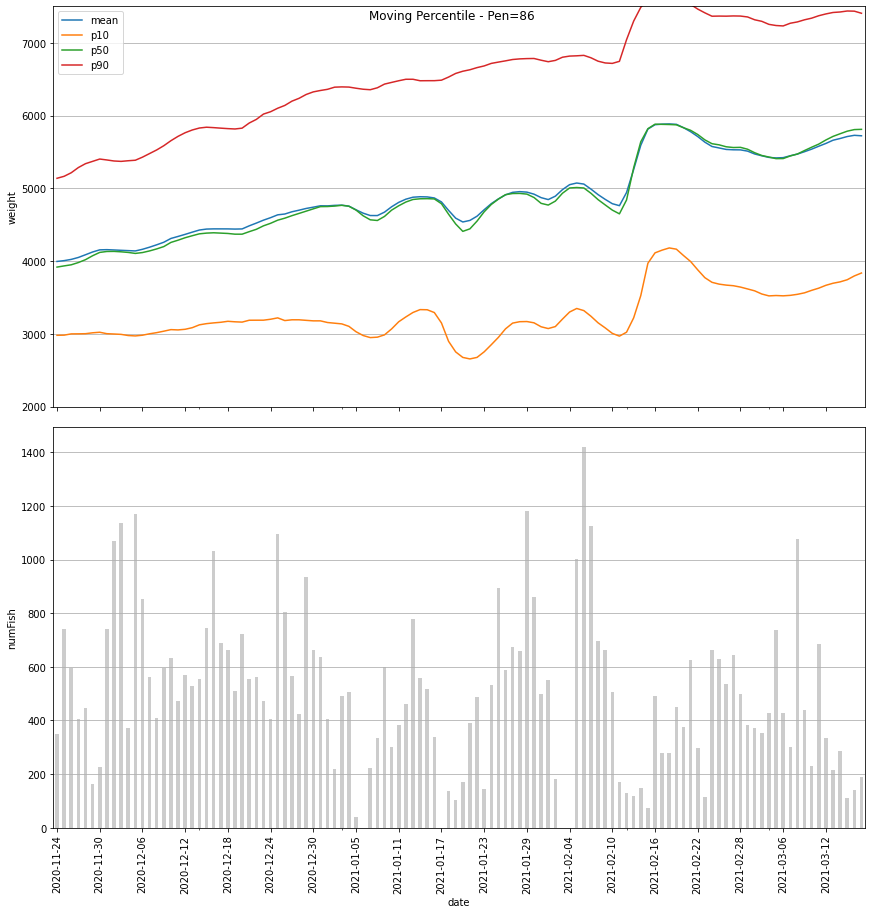

In [28]:
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,12),sharex=True)
fig.tight_layout()
with contextlib.redirect_stderr(StringIO()):
    moving_df['mean'].plot(ax=ax1,label='mean')
    moving_df['p10'].plot(ax=ax1,label='p10')
    moving_df['p50'].plot(ax=ax1,label='p50')
    moving_df['p90'].plot(ax=ax1,label='p90')
    moving_df['count'].plot.bar(ax=ax2, color='#ccc')
    ax1.grid(axis='y')
    ax1.set_ylabel('weight')
    ax1.set_ylim((2000,7500))
    ax1.legend()
    ax2.grid(axis='y')
    ax2.xaxis.set_major_locator(MaxNLocator(20)) 
    ax2.set_ylabel('numFish')
    fig.suptitle(f'Moving Percentile - Pen={pen_id}')

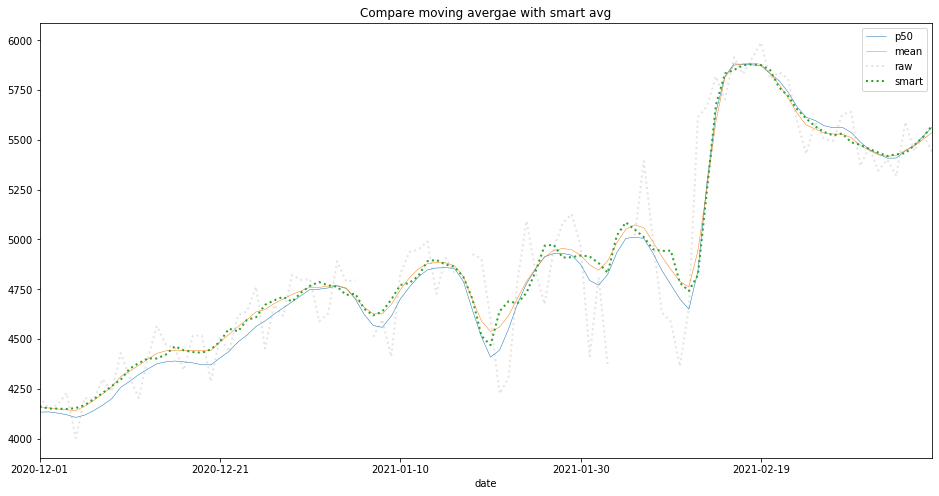

In [30]:
dfj = df_smart.join(moving_df, rsuffix='sp')

fig,ax1=plt.subplots(nrows=1,figsize=(16,8),sharex=True)
#fig.tight_layout()
with contextlib.redirect_stderr(StringIO()):
    dfj.p50.plot(ax=ax1,label='p50',lw=0.5)
    dfj['mean'].plot(ax=ax1,label='mean',lw=0.5)
    dfj.r_avgWeight.plot(ax=ax1,label='raw',c='#7773',ls=':',lw=2)
    dfj.s_avgWeight.plot(ax=ax1,label='smart',ls=':',lw=2)

ax1.legend()
ax1.set_title("Compare moving avergae with smart avg");

### Bootstrap moving percentile

In [ ]:
reload(S)
# def resample_smoothed(df):
#     # resample by day (by column 1)
#     idx_groups = df.groupby(by='day').apply(
#         lambda gi: np.random.choice(gi.index, len(gi), replace=True)
#     )
#     idx_flat = pd.Series(
#         itertools.chain.from_iterable(
#             group for group in idx_groups
#         )
#     )
#     resampled_df = df.loc[idx_flat]
#     return resampled_df.sort_index()



def bootstrap_iteration(i, df, pen_id, start_date, end_date, dates_to_include, dates_to_reset, dates_to_compute, estimate_feeding_hour=False):    
    print(f'Iteration {i+1}')   
    np.random.seed()

    num_calculation = len(dates_to_compute) - 4
    estimated_start_hour = np.zeros(num_calculation, np.int32)
    estimated_end_hour = np.zeros(num_calculation, np.int32)
    
    resampled_df = resample_by_day(df, day_column=1)
    
    sampling_filter = S.get_optimal_sampling_filter(pen_id)
    sampling_filter["estimate_feeding_hour"] = estimate_feeding_hour

    agg_data = {}
    for j in range(num_calculation):    
        di = dates_to_include[j:j+5+7+7]
        dc = dates_to_compute[j:j+5]
        if j+1 < num_calculation:
            di_end = dates_to_include[j+5+7+7]
        else:
            di_end = '2030-12-31'
        df_in_date = resampled_df[((resampled_df[0] >= di[0]) & (resampled_df[0] < di_end))]
        
        agg_j = S._generate_smart_metrics_step2(di, dates_to_reset, dc, sampling_filter, df_in_date.to_numpy())
        agg_data.update(agg_j)
        # thread safe?
        estimated_start_hour[j] = sampling_filter.get("estimated_start_hour", -1)
        estimated_end_hour[j] = sampling_filter.get("estimated_end_hour", -1)

    df = U.biomass_digest_df(agg_data)
    df = df.sort_values(by='date')
    r_w = df.r_avgWeight.to_numpy()
    s_w = df.s_avgWeight.to_numpy()
    
    return r_w, s_w, estimated_start_hour, estimated_end_hour, df


POOL_SIZE = 10

def bootstrap(pen_id, df, start_date, end_date, estimate_feeding_hour, sample_size):
    dates_to_include, dates_to_reset, dates_to_compute = smart_metrics_date_params(pen_id, start_date, end_date, [])
    
    b_func = functools.partial(bootstrap_iteration, df=df, pen_id=pen_id, start_date=start_date, end_date=end_date, 
                               dates_to_include=dates_to_include, dates_to_reset=dates_to_reset, dates_to_compute=dates_to_compute, 
                               estimate_feeding_hour=estimate_feeding_hour)

    with multiprocessing.Pool(processes=POOL_SIZE) as pool:
        result = pool.map(b_func, range(sample_size), chunksize=1)

    agg_df = result[0][4] # use the first df for now
    r_w = np.array([r[0] for r in result]).T
    s_w = np.array([r[1] for r in result]).T
    start_hours = np.array([r[2] for r in result])
    end_hours = np.array([r[3] for r in result])

    logging.info(f"Bootstrap size={sample_size} -> r_w={len(r_w)}, s_w={len(s_w)}, dates={len(dates)})")
    
    return agg_df, r_w, s_w, start_hours, end_hours

In [65]:
def bootstrap_iteration_moving(i, df, pen_id):
    print(f'bootstrap_iteration_moving {i+1}')    
    np.random.seed()

    resampled_df = resample_by_day(df, day_column='day')
    
    quantiles = [0.1, 0.5, 0.9]
    date0 = resampled_df[0].min().date()
    
    result = []
    for day_idx in range(resampled_df['day'].max() + 1):
        date = str(date0 + pd.Timedelta(days=day_idx))
        count, q = weighted_metric_on_day(resampled_df, day_idx, quantiles)
        result.append(dict(
            day_idx = day_idx,
            date    = date,
            count   = count,
            mean    = q[0],
            p10     = q[1],
            p50     = q[2],
            p90     = q[3],        
        ))
        assert not np.isnan(q).any()

    return pd.DataFrame(result).set_index('date')


POOL_SIZE = 10

def bootstrap_moving(pen_id, df, sample_size):
    b_func = functools.partial(bootstrap_iteration_moving, pen_id=pen_id, df=df)
    with multiprocessing.Pool(processes=POOL_SIZE) as pool:
        result = pool.map(b_func, range(sample_size), chunksize=1)
        
    agg_df = result[0] # use the first df
    num_days = len(agg_df)
    b_mean = np.zeros((num_days, sample_size))
    b_p10 = np.zeros((num_days, sample_size))
    b_p50 = np.zeros((num_days, sample_size))
    b_p90 = np.zeros((num_days, sample_size))
    for i, df in enumerate(result):
        b_mean[:,i] = df['mean']
        b_p10[:,i] = df['p10']
        b_p50[:,i] = df['p50']
        b_p90[:,i] = df['p90']
        
    return agg_df, b_mean, b_p10, b_p50, b_p90

#bootstrap_iteration_moving(1, biomass_day_df, pen_id)

In [ ]:
sample_size = 100
result_moving_86 = bootstrap_moving(86, biomass_day_df, sample_size)
agg_df, b_mean, b_p10, b_p50, b_p90 = result_moving_86
print(b_mean.shape)

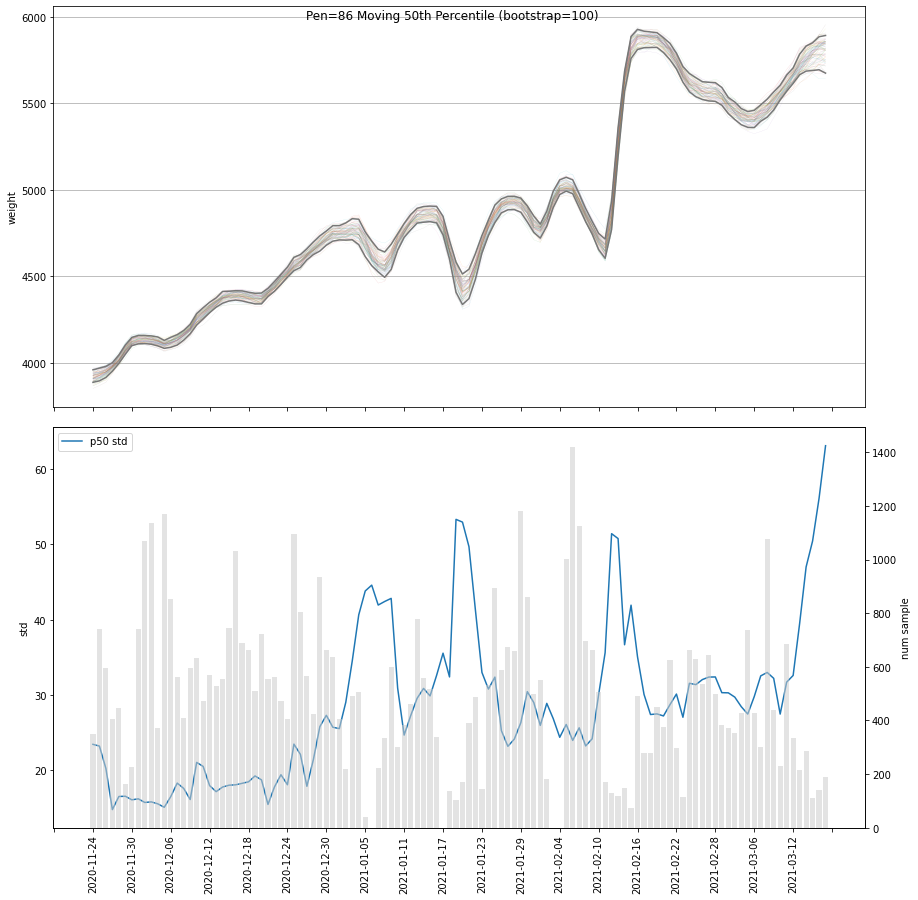

In [70]:
logging.getLogger().setLevel(logging.WARNING)
fig,(ax1,ax2) = plt.subplots(figsize=(12,12), nrows=2, sharex=True, facecolor='w')
fig.tight_layout()
plt.xticks(rotation=90)

sample_size = b_mean.shape[1]
for i in range(sample_size):
#    ax1.plot(agg_df.index, b_p10[:,i], lw=0.2)
    ax1.plot(agg_df.index, b_p50[:,i], lw=0.05)
#    ax1.plot(agg_df.index, b_p90[:,i], lw=0.05)
ax1.plot(agg_df.index, np.percentile(b_p50, q=95, axis=1), color='#777')
ax1.plot(agg_df.index, np.percentile(b_p50, q=5, axis=1), color='#777')    
#ax1.set_ylim((4000,5000))
ax1.set_ylabel('weight')
ax1.grid(axis='y')


#ax2.plot(np.std(b_p90, axis=1),label='p90 std')
ax2.plot(np.std(b_p50, axis=1),label='p50 std')
#ax2.plot(np.std(b_p10, axis=1),label='p10 std')
ax2.set_ylabel('std')
ax2.legend()
ax2_ = ax2.twinx()
ax2_.bar(x=agg_df.index, height=agg_df['count'], color='#ccc8',)
ax2_.set_ylabel('num sample')
ax2.xaxis.set_major_locator(MaxNLocator(25)) 

fig.suptitle(f'Pen={pen_id} Moving 50th Percentile (bootstrap={sample_size})')

logging.getLogger().setLevel(logging.INFO)

## Visualize feeding hour

In [772]:
def jitter(a, loc=0.0, scale=0.1):
    return a + np.random.normal(loc, scale, a.shape)

estimated_start_hour = jitter(np.sort(start_hours, axis=0) * 1.0)
estimated_end_hour = jitter(np.sort(end_hours, axis=0) * 1.0)

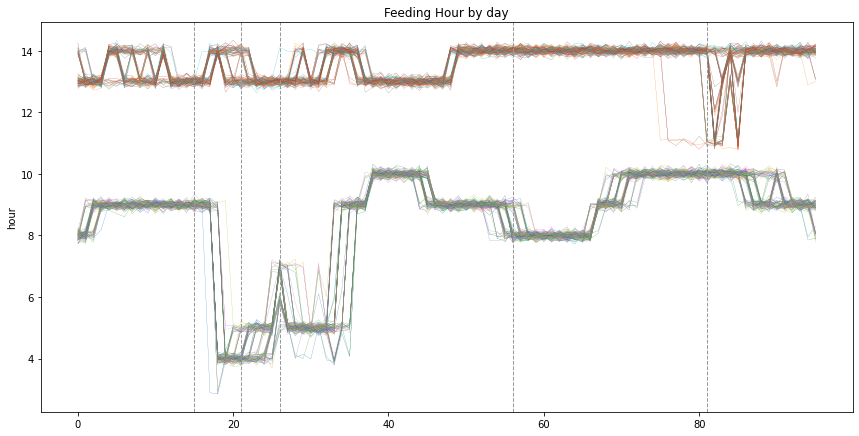

In [773]:
logging.getLogger().setLevel(logging.WARNING)
fig,ax1 = plt.subplots(figsize=(12,6), nrows=1, facecolor='w')
fig.tight_layout()

for i in range(SAMPLE_SIZE):
    ax1.plot(estimated_start_hour[i,:], lw=0.2)
    ax1.plot(estimated_end_hour[i,:], lw=0.2)
ax1.set_title("Feeding Hour by day")
ax1.set_ylabel("hour")

for d in (15,21,26,56,81):
    ax1.axvline(d, lw=1, ls='--', c='#999')

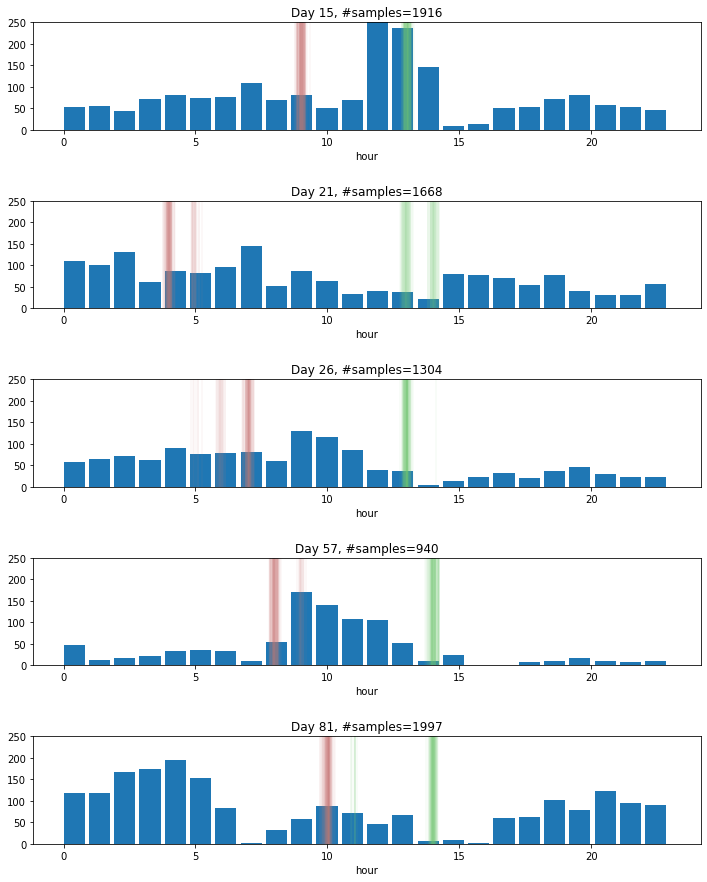

In [777]:
fig, axes = plt.subplots(figsize=(10,12), nrows=5, facecolor='w')
fig.tight_layout(h_pad=5)

for day_idx, ax in zip([15, 21, 26, 57, 81], axes):
    day = df.index[day_idx]
    ddf = biomass_df[biomass_df[1] == day]
    hours = ddf[0].apply(lambda d: d.hour)
    ax.hist(hours, width=0.8, bins=24);
    ax.set_ylim((0,250))
    ax.set_xlabel("hour")
    ax.set_title(f"Day {day_idx}, #samples={len(ddf)}")
    
    for i in range(SAMPLE_SIZE):
        ax.axvline(estimated_start_hour[i,day_idx], lw=0.1, c="#c77")
        ax.axvline(estimated_end_hour[i,day_idx], lw=0.1, c="#7c7")        

# Agg (junk?)

In [ ]:
L.get_partialfish_lice_data_from_db(4,['2021-01-10', '2021-01-15'])

In [ ]:
data_store = 'PROD_STAGING'
argslist = [(55, 101, '2020-12-02', 'null')]

# B.write_day_summary(data_store, argslist)
sql = """\
INSERT INTO day_summaries (
    site_id,
    pen_id,
    date,
    biomass_data
) VALUES %s
"""
"""
ON CONFLICT (pen_id, date)
DO UPDATE SET
    updated_at = now(),
    biomass_data = excluded.biomass_data
;
"""
U.upsert_query(sql, argslist, data_store=data_store)

In [ ]:
d = {
    'penId': '123',
    'startDate': '2021-01-12',
    'endDate': '2021-01-14',
    'datesToReset': [],
}
d = S.generate_smart_metrics(d)

In [ ]:
summary = []
for date, payload in d.items():
    r = payload['rawData']
    s = payload['smartData']
    summary.append((
        date, 
        r['numFish'], 
        r['avgWeight'],
        s['numFish'], 
        s['avgWeight'],
        s['growthRate'],
        s['biomassKPI'],
    ))
pp(summary)    

In [ ]:
import csv
from pathlib import Path
def load_data_biomass_data():
    p = Path('/home/wai/work/production_algo/aggregation_service/tests/resources/biomass_data_pen_123.csv')
    reader = csv.reader(p.open())
    next(reader)
    data = []
    for row in reader:
        data.append((
            row[0], 
            float(row[1]),
            float(row[2]),
        ))
    return data
    
load_data_biomass_data()[:3]


In [ ]:

>>> import sched, time
>>> s = sched.scheduler(time.time, time.sleep)
>>> def print_time(a='default'):
...     print("From print_time", time.time(), a)
...
>>> def print_some_times():
...     print(time.time())
...     s.enter(10, 1, print_time)
...     s.enter(5, 2, print_time, argument=('positional',))
...     s.enter(5, 1, print_time, kwargs={'a': 'keyword'})
...     s.run()
...     print(time.time())

In [28]:
df=pd.read_csv(open('sql/dale_pen_3_data_duplicate.csv'))

In [34]:
df1 = df[df.is_duplicate != 0]